In [1]:
%matplotlib inline

In [2]:
from adaptmesh import triangulate
import numpy as np

/home/tom/.conda/envs/vedoenv/lib/python3.8/site-packages/adaptmesh/tri/delaunay.py:13: UserWarning: Robust predicates not available, falling back on non-robust implementation
  warnings.warn(


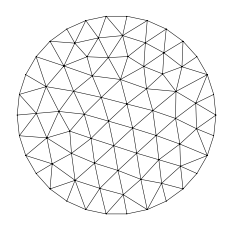

In [3]:
m = triangulate([(np.cos(t), np.sin(t)) for t in np.linspace(0, 2.*np.pi, 30, endpoint=False)], quality=0.95)
m.draw()

/home/tom/.conda/envs/vedoenv/lib/python3.8/site-packages/adaptmesh/process.py:47: UserWarning: Criterion not satisfied in 10 refinement loops.
  warnings.warn(


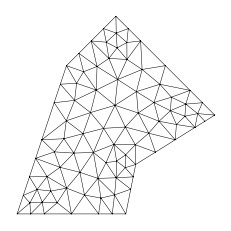

In [4]:
m = triangulate([
    (0.0, 0.0),
    (1.1, 0.0),
    (1.2, 0.5),
    (0.7, 0.6),
    (2.0, 1.0),
    (1.0, 2.0),
    (0.5, 1.5),], max_refloops=10, quality=0.92)
m.draw()

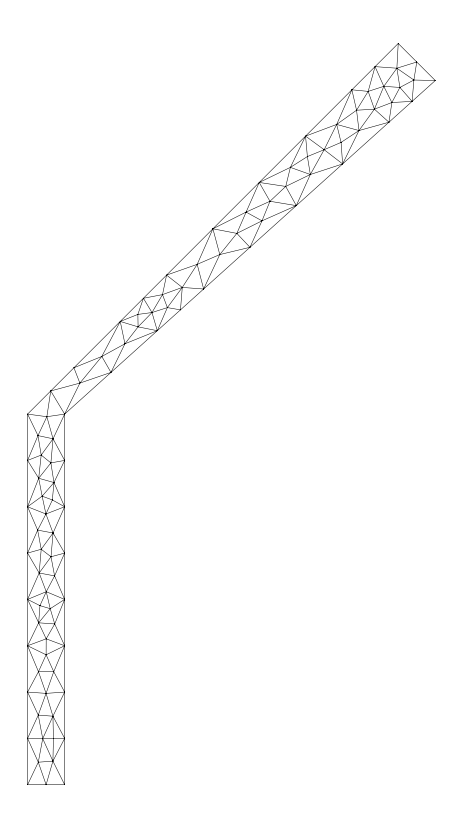

In [5]:
m = triangulate([
    (0.0, 0.0),
    (5.0, 5.0),
    (5.5, 4.5),
    (0.5, 0.0),
    (0.5, -5.0),
    (0., -5.0),], max_refloops=30, quality=0.7)
m.draw(figsize=(15,15))

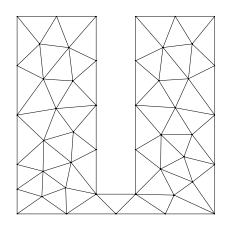

In [6]:
m = triangulate([(0., 0.),
              (1., 0.),
              (1., 1.),
              (.6, 1.),
              (.6, .1),
              (.4, .1),
              (.4, 1.),
              (0., 1.)])
m.draw()

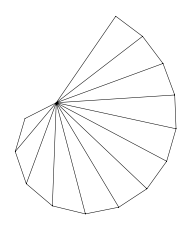

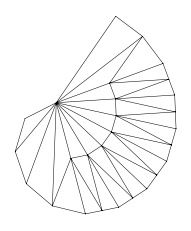

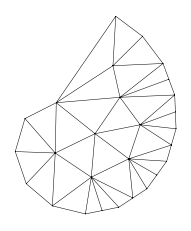

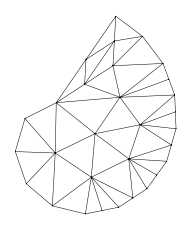

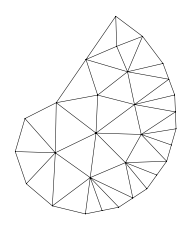

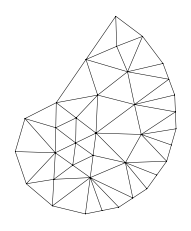

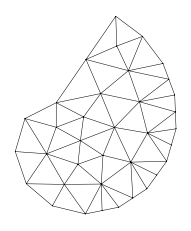

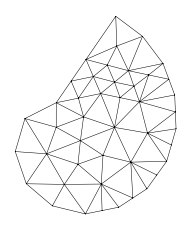

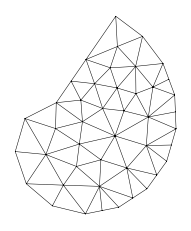

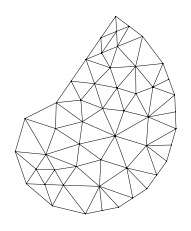

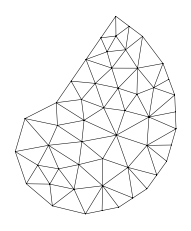

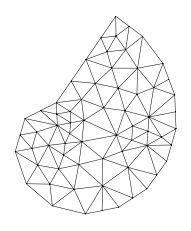

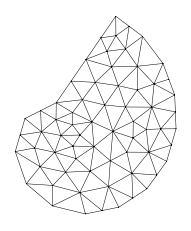

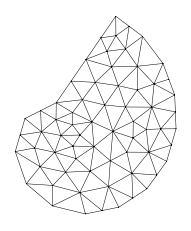

In [7]:
m = triangulate([
(-0.416  , 0.909),
(-1.35  ,  0.436),
(-1.64  , -0.549),
(-1.31  , -1.51),
(-0.532  ,-2.17),
( 0.454 , -2.41),
( 1.45 ,  -2.21),
( 2.29 ,  -1.66),
( 2.88 ,  -0.838),
( 3.16 ,   0.131),
( 3.12 ,   1.14),
( 2.77 ,   2.08),
( 2.16 ,   2.89),
( 1.36 ,   3.49)], verbose=True)
m.draw()

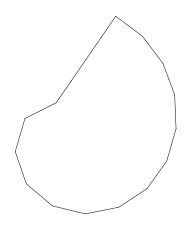

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
aspect = 1.0
ax.set_aspect(aspect)
ax.set_axis_off()
plt.plot(m.p[0, m.facets[:, m.boundary_facets()]], m.p[1, m.facets[:, m.boundary_facets()]], 'k-',linewidth='0.5')

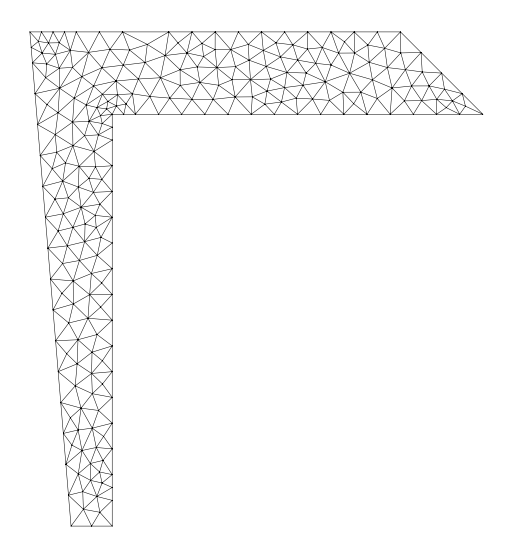

In [9]:
m = triangulate([(0.,0.),
              (0.1,0.),
              (0.1,1.0),
              (1.,1.),
              (0.8,1.2),
              (-0.1,1.2),]) 
m.draw(figsize=(10,10))

/home/tom/.conda/envs/vedoenv/lib/python3.8/site-packages/adaptmesh/process.py:47: UserWarning: Criterion not satisfied in 10 refinement loops.
  warnings.warn(


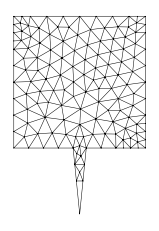

In [10]:
m = triangulate([(0.,0.),
              (0.45,0.),
              (0.5,-0.5),
              (0.55,0.),
              (1.,0.),
              (1.,1.),
             (0.,1.)], max_refloops=10, quality=0.95) 
m.draw()

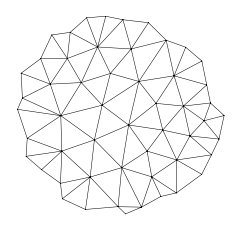

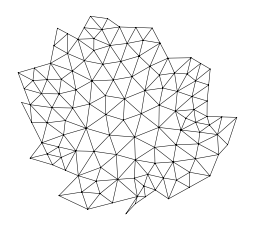

In [11]:
from numpy import random
random.seed(25)
m = triangulate([(np.cos(t)+random.rand()/5, np.sin(t)+random.rand()/5) for t in np.linspace(0, 2.*np.pi, 30, endpoint=False)],
               quality=0.9) 
m.draw()
random.seed(25)
m = triangulate([(np.cos(t)+random.rand()/2, np.sin(t)+random.rand()/2) for t in np.linspace(0, 2.*np.pi, 30, endpoint=False)],
               quality=0.90)
m.draw()

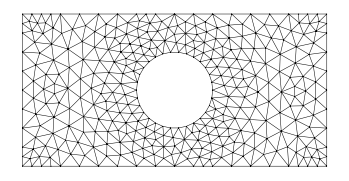

In [16]:
m = triangulate([[-4, -2], [-4, 2], [4, 2], [4, -2]],
                holes=[[(np.cos(t), np.sin(t)) for t in np.linspace(0, 2.*np.pi, 30, endpoint=False)]],
                quality=0.92)
m.draw()

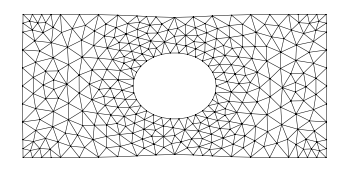

In [20]:
from skfem import *
from skfem.models.elasticity import *
import numpy as np

e = ElementVectorH1(ElementTriP2())
basis = InteriorBasis(m, e, intorder=3)
fbasis = FacetBasis(m, e)

A = linear_elasticity(1., 1.).assemble(basis)

@BilinearForm
def mass(u, v, w):
    from skfem.helpers import dot
    return dot(u, v)

M = mass.assemble(basis)

@LinearForm
def load(v, w):
    from skfem.helpers import dot
    x, _ = w.x
    return 1e-1 * (np.abs(x) == 4.) * w.n[0] * v.value[0]

b = load.assemble(fbasis)

x = solve(A + 1e-6 * M, b)

mdefo = m.copy()
mdefo.p[0] += x[basis.nodal_dofs[0]]
mdefo.p[1] += x[basis.nodal_dofs[1]]

from skfem.visuals.matplotlib import draw
draw(mdefo)

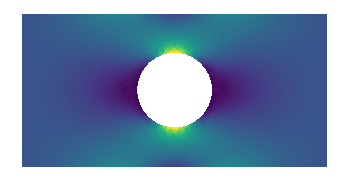

In [30]:
from skfem.helpers import sym_grad

@BilinearForm
def stress_xx(u, v, w):
    return linear_stress(1., 1.)(sym_grad(u))[0, 0] * v

@BilinearForm
def scalar_mass(u, v, w):
    return u * v

E = ElementTriDG(ElementTriP1())

pbasis = InteriorBasis(m, E, intorder=3)

P = stress_xx.assemble(basis, pbasis)
y = solve(scalar_mass.assemble(pbasis), P.dot(x))

from skfem.visuals.matplotlib import plot
plot(pbasis, y, Nrefs=4)

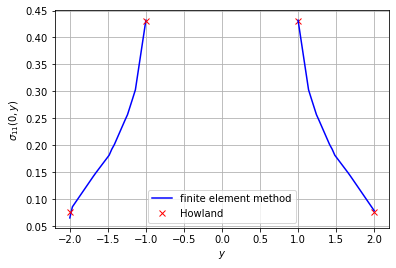

In [56]:
fun = pbasis.interpolator(y)

import matplotlib.pyplot as plt

Y = np.linspace(-2, -1, 30)
X = np.array([0. * Y, Y])
plt.plot(Y, fun(X), 'b-')
plt.plot([-2, -1, 1, 2],[0.75 * 1e-1, 4.3 * 1e-1, 4.3 * 1e-1, 0.75 * 1e-1],'rx')
Y = np.linspace(1, 2, 30)
X = np.array([0. * Y, Y])
plt.plot(Y, fun(X), 'b-')
plt.xlabel('$y$')
plt.ylabel('$\sigma_{11}(0,y)$')
plt.grid('on')
plt.legend(['finite element method', 'Howland'])